In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import time
import DNN
%matplotlib inline

### Load the data

In [8]:
details = json.loads(open("details.json", "r").read())
X_data_path = details['coin'] + "_" + details['prediction'] + "_data.csv"
Y_data_path = details['coin'] + "_" + details['prediction'] + "_data.csv"

X_data_raw = pd.read_csv(X_data_path)
Y_data_raw = pd.read_csv(Y_data_path)

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

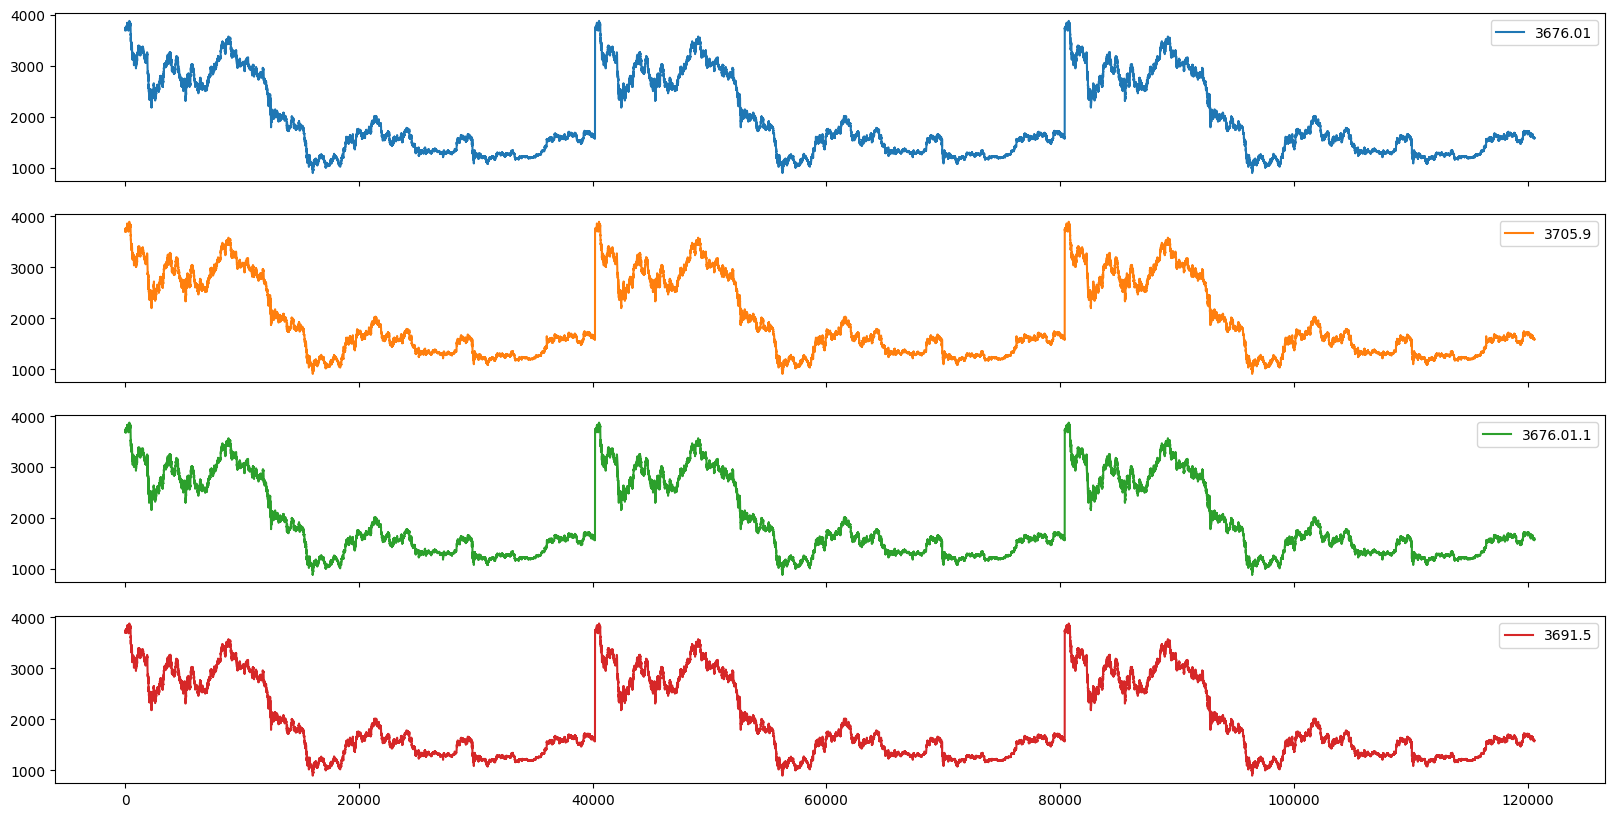

In [9]:
#get only columns: open,	high,	low,	close
X_data_raw = X_data_raw.iloc[:,2:6]
Y_data_raw = Y_data_raw.iloc[:,2:6]

#show data with each column is a different color
X_data_raw.plot(subplots=True, figsize=(20,10))


In [10]:
#to numpy 
X_data_raw = X_data_raw.to_numpy()
Y_data_raw = Y_data_raw.to_numpy()


### Calculate the true labels
---------

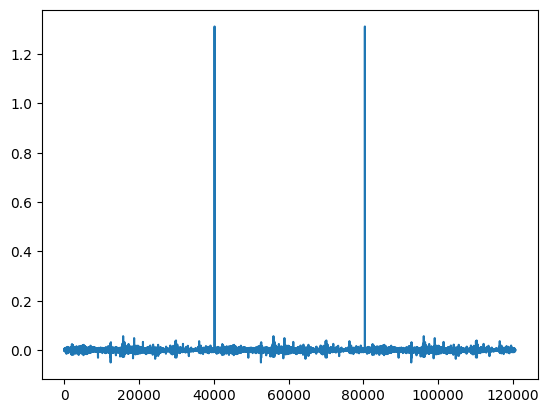

In [16]:
labels = details['label']

#open + close / 2
Y_data = (Y_data_raw[:,0] + Y_data_raw[:,3]) / 2

# Y_data[i] - Y_data[i-1]
Y_data_diff = np.diff(Y_data)

#calculate the percentage change
Y_data = Y_data_diff / Y_data[:-1]

#show the data
plt.plot(Y_data)
plt.show()


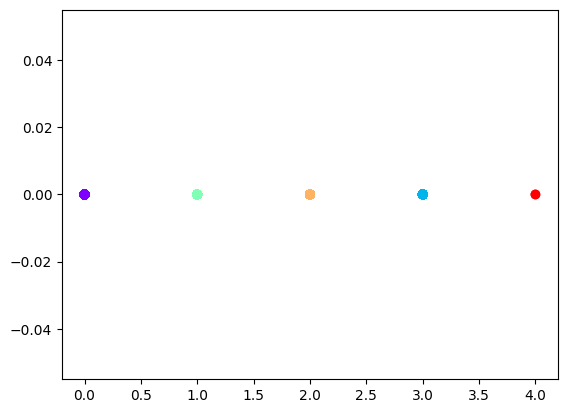

In [15]:
#Using k-means to cluster the data into 5 groups, scatter plot
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(Y_data.reshape(-1,1))
plt.scatter(Y_data, np.zeros(Y_data.shape), c=kmeans.labels_, cmap='rainbow')
plt.show()


In [7]:

#classify Y based on thresholds
Y = np.digitize(Y_data, THRESHOLDS)
#create Y as one hot
Y = np.eye(len(THRESHOLDS)+1)[Y]


In [8]:

LAYERS = 10
#using X[0:10] to predict Y[11]
Y = Y[LAYERS:]
X = np.zeros((X_data.shape[0] - LAYERS , LAYERS)) #+1
for i in range(X_data.shape[0] - LAYERS ):

    X[i] = X_data[i:i+LAYERS ]



In [9]:
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [10]:
LEARNING_RATE = 0.0001
ITERATIONS = 100
#train the neural net with 256 
LAYERS = [512, 256, 256, 5]
ACTIVATION = [ "relu", "relu", "relu", "sigmoid"]

In [11]:
model = DNN.create_model(LAYERS,ACTIVATION)
parameters = DNN.train_model(model, X_train, y_train, X_test, y_test, epochs=ITERATIONS, batch_size=32)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

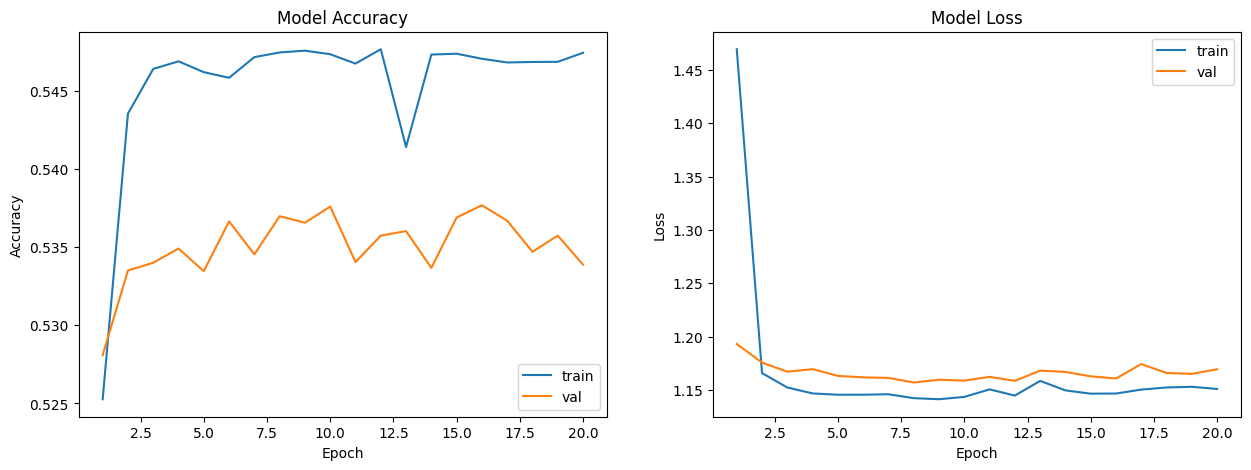

In [13]:
DNN.plot_model_history(parameters)